In [2]:
import pickle
from datetime import datetime

import numpy as np 
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
# Read in original data
all_data_pkl = open("all_data.pkl","rb")
all_data = pickle.load(all_data_pkl)
all_data[['call','ex_tag']] = all_data[['call','ex_tag']].astype('int')
data_no_extag = all_data[all_data['ex_tag']==0]


# Read in w2v and b-o-w transformed data
tfidf_pkl = open("tfidf_pkl.pkl","rb")
tfidf_features = pd.read_csv("features.csv")["0"]

# Check dimonsionality
tfidf_df = pickle.load(tfidf_pkl)
print(tfidf_df.shape)
print(data_no_extag.shape)
print("Positive %: ",sum(data_no_extag['call'])/data_no_extag.shape[0],)
data_no_extag[:3]

(13418, 500)
(13418, 4)
Positive %:  0.15270532121


,id,call,ex_tag,txt
0,CTRL000000096,0,0,Subject: FW: Quality Moves to utilize on your ...
1,CTRL000000097,0,0,"Subject: Schedule confirmation From: guzman, M..."
2,CTRL000000099,0,0,"Subject: Emergency Meeting From: ""williams iii..."


## PCA using SVD

### 1. Extract PCs

#### Caveat: make sure you center the data!!
       EG. one feature is height in feet, one feature is width in inches

In [33]:
scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
tfidf_df_scaled = scaler.fit_transform(tfidf_df)
print("---> Average mean after standardization: ", tfidf_df_scaled.mean())
print("---> Average std. after standardization: ", tfidf_df_scaled.std())

---> Average mean after standardization:  -1.01672533363e-18
---> Average std. after standardization:  1.0


In [34]:
tfidf_df_scaled = scaler.fit_transform(tfidf_df)

In [35]:
pca = PCA()
pca.fit(tfidf_df_scaled)

PCA(copy=True, n_components=None, whiten=False)

<IPython.core.display.Javascript object>


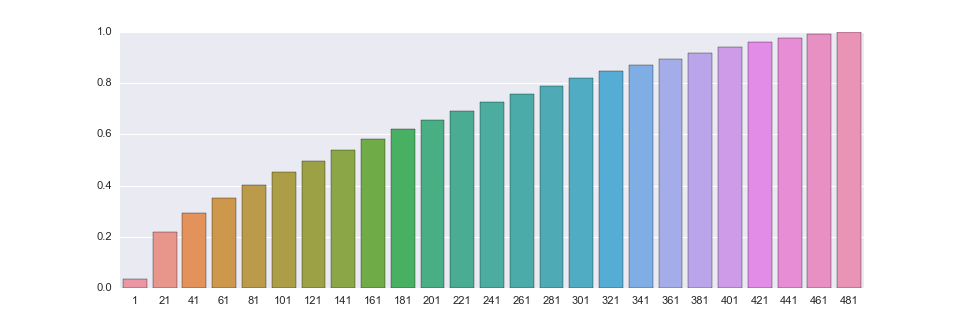

In [38]:
fig1 = plt.figure(figsize=(12,4))
ax1 = fig1.add_subplot(111)

PCnums = [x+1 for x in range(len(pca.explained_variance_ratio_)) if x % 20 == 0]
cum_var = np.cumsum(pca.explained_variance_ratio_)[[x for x in range(len(pca.explained_variance_ratio_)) if x % 20 == 0]]
sns.barplot(PCnums,cum_var,ax=ax1)

### 2. Interpret PCs / Latent topics

In [53]:
PCs_df = pd.DataFrame(pca.components_, columns = tfidf_df.columns)
print(PCs_df.shape)

print("-----> This is the 1st PC/latent topic\n ----> although I have no idea what it is about =n=")
print((PCs_df.iloc[0,:]).sort_values(ascending=False))

(500, 500)
-----> This is the 1rs PC/latent topic
 ----> although I have no idea what it is about =n=
shall                    0.022711
obligations              0.020692
parties                  0.020510
aordance                 0.020385
heunder                  0.019998
applicable               0.019820
agement                  0.019022
spect                    0.017853
party                    0.017729
pursuant                 0.017480
forth                    0.017390
buyer                    0.017299
damages                  0.016616
terms                    0.016391
period                   0.016038
delivery                 0.015888
including                0.015844
payment                  0.015805
company                  0.015795
transaction              0.015068
amounts                  0.014956
means                    0.014789
quantity                 0.014722
rights                   0.014548
gas                      0.014506
seller                   0.014422
provided      

### 3. Use PCA to transform data

In [97]:
tfidf_transformed = pca.transform(tfidf_df_scaled)
print(tfidf_transformed.shape)   
print(tfidf_transformed[:,0:50].shape) # We will use only the first 50 columns LOL

(13418, 500)
(13418, 50)


In [92]:
# Benchmark
X_train,X_test,y_train,y_test = train_test_split(tfidf_df, data_no_extag['call'], test_size = 0.95, random_state = 1)

# PCA
X_train_pca,X_test_pca,y_train_pca,y_test_pca = train_test_split(tfidf_transformed[:,0:50], data_no_extag['call'], test_size = 0.95, random_state = 1)

# Note that y_train and y_train_pca are the same

In [93]:
X_train_pca.shape

(670, 50)

In [94]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)


rf_pca = RandomForestClassifier(n_estimators=200)
rf_pca.fit(X_train_pca,y_train_pca)
y_pred_pca = rf_pca.predict(X_test_pca)

In [95]:
# A helper function to get metrics
def get_metrics(y_truth, y_predicted, p_label, return_flag = False):
    confusion_matrix = metrics.confusion_matrix(y_truth, y_predicted, labels = [1,0])
    accuracy = round((metrics.accuracy_score(y_truth, y_predicted)), 2)
    precision = round((metrics.precision_score(y_truth, y_predicted, pos_label = p_label, average = 'binary')), 2)
    recall = round((metrics.recall_score(y_truth, y_predicted, pos_label = p_label, average = 'binary')), 2)
    
    if(return_flag):
        return(pd.DataFrame([accuracy,precision,recall]).transpose())
    else:
        print ("Confusion Matrix:")
        print (confusion_matrix)
        print ()
        print ("Accuracy: %f;\nPrecision: %f;\nRecall: %f;" %(accuracy, precision, recall))

In [96]:
print("-----> Original Results: 500 top tfidf words")
get_metrics(y_pred,y_test,p_label=1)

print("-----> PCA results (should be worse): 50 PCs/latent topics extract from the 500 words")  ## Note: the results hardly get hurt!!!
get_metrics(y_pred_pca,y_test,p_label=1)

-----> Original Results: 500 top tfidf words
Confusion Matrix:
[[  910    79]
 [ 1047 10712]]

Accuracy: 0.910000;
Precision: 0.460000;
Recall: 0.920000;
-----> PCA results (should be worse): 50 PCs/latent topics extract from the 500 words
Confusion Matrix:
[[  870    86]
 [ 1087 10705]]

Accuracy: 0.910000;
Precision: 0.440000;
Recall: 0.910000;


### This is an application in supervised context; could use PCs to do clustering...

### TakeAways:
#### 1. LSA does work very well when there are really no concentrated latent topics... (e.g. emails)
#### 2. That said, variation in data could have nothing to do with our goal (e.g. the last 450 PCs might have nothing informative about gambling), so we could still leverage its ability to reduce dimensions.